# Exercice 1. CNN for object classification

Le jeu de données Toy Dataset - v7 2023-04-19 1:21am est fourni par Roboflow (https://universe.roboflow.com/tips-wis6y/toy-dataset-bfq0d). Vous en trouverez une copie sur la page Moodle.

Les données brutes se trouvent dans le sous-dossier « images ». Les données d'étiquetage se trouvent dans le sous-dossier « labels ».

Le format des données d'étiquetage est le suivant :

    categ, cx, cy, w, h

où categ représente le numéro de catégorie, cx et cy les coordonnées du centre de l'objet (sur une échelle de 0 à 1), et w et h ses valeurs horizontale et verticale (exprimées en pourcentage de la largeur et de la hauteur). (cx, cy, w, h) constitue le cadre englobant de l'objet. Cette représentation est conforme au format YOLO8.

Afin d'exploiter tous les objets présents dans les images, lors du chargement du jeu de données, nous pouvons extraire les images des objets à partir des images originales en les recadrant à l'intérieur de leur cadre englobant.

Deux configurations sont présentées ci-dessous :

    all objects versus all objects (load_objects)
    one object versus all (load_objects_as_binary_problem)

**Q1** Vous pouvez utiliser le code tel quel, mais vous pouvez également le modifier afin d'obtenir un équilibre entre les classes, notamment pour la classification binaire. Pourquoi pensez-vous que cela peut être intéressant d'équilibrer entre les classes ?

Équilibrer les classes est important parce que, lorsqu’un jeu de données est déséquilibré, le réseau de neurones a tendance à favoriser la classe majoritaire

In [1]:
import os
import csv
import cv2
import numpy as np
import math
import random

data_path = "../data/toy-dataset"
train_path = os.path.join(data_path, "train/")
test_path = os.path.join(data_path, "test/")

def load_objects(imgs_path,max_samples=np.iinfo(np.int32)):
    y_obj=[]
    x_obj=[]
    imgs_files = os.listdir( imgs_path+"images/" )
    for i,img_file in enumerate(imgs_files):
        if (len(x_obj)==max_samples):
            break
        label_file=img_file[:-4]+".txt"
        img_init=cv2.imread(imgs_path+"images/"+img_file)
        labels=csv.reader(open(imgs_path+"labels/"+label_file,"r"),delimiter=' ')
        rows = list(labels)
        if len(rows)>0:
            for j,row in enumerate(rows):
                if (len(x_obj)==max_samples):
                    break
                y_obj.append(int(row[0]))
                bbox=np.array(row[1:],dtype=np.float32) if row[0]==1 else np.array(row[1:],dtype=np.float32)
                w=int(bbox[2]*img_init.shape[0]*2)
                h=int(bbox[3]*img_init.shape[1]*2)
                x0=max(0,int(bbox[0]*img_init.shape[0]-w/2))
                y0=max(0,int(bbox[1]*img_init.shape[1]-h/2))
                x1=min(img_init.shape[0],int(math.trunc(x0+w)))
                y1=min(img_init.shape[1],int(math.trunc(y0+h)))
                x_obj.append(np.copy(img_init[y0:y1,x0:x1]))
    return x_obj,y_obj
                
def load_objects_as_binary_problem(imgs_path,max_samples=np.iinfo(np.int32)):
    y_obj=[]
    x_obj=[]
    imgs_files = os.listdir( imgs_path+"images/" )
    for i,img_file in enumerate(imgs_files):
        if (len(x_obj)==max_samples):
            break
        label_file=img_file[:-4]+".txt"
        #print(i,img_file,label_file)
        img_init=cv2.imread(imgs_path+"images/"+img_file)
        labels=csv.reader(open(imgs_path+"labels/"+label_file,"r"),delimiter=' ')
        rows = list(labels)
        if len(rows)>0:
            for j,row in enumerate(rows):
                if (len(x_obj)==max_samples):
                    break
                if (row[0]=='4'):
                    y_obj.append(int(row[0]))
                else:
                    y_obj.append(0)
                bbox=np.array(row[1:],dtype=np.float32) if row[0]==1 else np.array(row[1:],dtype=np.float32)
                w=int(bbox[2]*img_init.shape[0])
                h=int(bbox[3]*img_init.shape[1])
                x0=max(0,int(bbox[0]*img_init.shape[0]-w/2))
                y0=max(0,int(bbox[1]*img_init.shape[1]-h/2))
                x1=min(img_init.shape[0],int(math.trunc(x0+w)))
                y1=min(img_init.shape[1],int(math.trunc(y0+h)))
                x_obj.append(img_init[y0:y1,x0:x1].copy())
    return x_obj,y_obj

In [2]:
def load_objects_as_binary_problem_balanced(imgs_path, max_positivesamples=np.iinfo(np.int32)):
    x_pos, y_pos = [], []
    x_neg, y_neg = [], []

    imgs_files = os.listdir(imgs_path + "images/")

    for img_file in imgs_files:
        label_file = img_file[:-4] + ".txt"
        img_init = cv2.imread(imgs_path + "images/" + img_file)

        labels = csv.reader(
            open(imgs_path + "labels/" + label_file, "r"),
            delimiter=' '
        )
        rows = list(labels)

        for row in rows:
            bbox = np.array(row[1:], dtype=np.float32)

            w = int(bbox[2] * img_init.shape[0])
            h = int(bbox[3] * img_init.shape[1])

            
            x0 = max(0, int(bbox[0]*img_init.shape[0] - w/2))
            y0 = max(0, int(bbox[1]*img_init.shape[1] - h/2))
            x1 = min(img_init.shape[0], x0 + w)
            y1 = min(img_init.shape[1], y0 + h)

            crop = img_init[y0:y1, x0:x1].copy()
            if crop.size == 0:
                continue

            # Classe positive = 4
            if row[0] == '4':
                if len(x_pos) < max_positivesamples:
                    x_pos.append(crop)
                    y_pos.append(1)
            else:
                x_neg.append(crop)
                y_neg.append(0)

    # Équilibrage : même nombre de négatifs que de positifs
    n_pos = len(x_pos)
    x_neg = x_neg[:n_pos]
    y_neg = y_neg[:n_pos]

    # Fusion et mélange
    x_obj = x_pos + x_neg
    y_obj = y_pos + y_neg
    combined = list(zip(x_obj, y_obj))
    random.shuffle(combined)
    x_obj, y_obj = zip(*combined)

    return list(x_obj), list(y_obj)


## Architectures légères

Essayez des architectures simples combinant une ou deux couches de convolution et de pooling, suivies d'une ou deux couches denses.

Pour la classification binaire, la dernière couche ne comporte qu'un seul neurone.

Pour la classification multicatégorielle, la dernière couche comporte autant de neurones que de catégories. Le neurone gagnant est celui qui a la valeur de sortie la plus élevée. Un encodage des étiquettes catégorielles est nécessaire pour préparer les données d'entraînement (voir `tf.keras.utils.to_categorical`).

Vous pouvez choisir le framework (PyTorch ou TensorFlow) avec lequel vous êtes à l'aise.

Vous pouvez travailler en local ou sur Google Colab.

Vous trouverez ci-dessous un exemple de code TensorFlow incomplet pour résoudre ce problème, mais vous pouvez le remplacer complétement par une solution de votre choix.

In [3]:
def layout_images(images, n=4):
    fig, axes = plt.subplots(1, n, figsize=(12, 3))
    for i in range(n):
        axes[i].imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        axes[i].axis('off')
    plt.show()

def resize(imgs, target_resize=(128, 128)):
    resized_imgs = []
    for img in imgs:
        img_resized = cv2.resize(img, target_resize)
        resized_imgs.append(img_resized)
    return np.array(resized_imgs)


2026-02-09 14:26:39.577163: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-09 14:26:39.577361: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-09 14:26:39.610771: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-09 14:26:40.561089: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

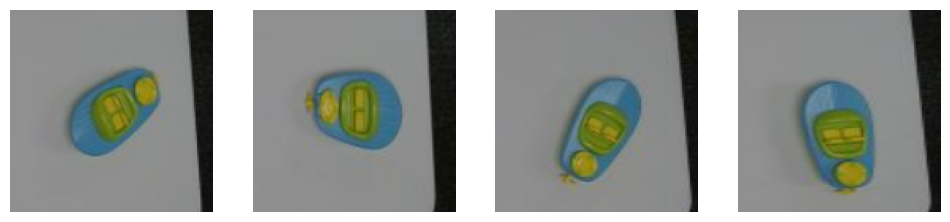

2026-02-09 14:26:42.877143: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 124, 124, 64)   │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    62,980,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │         3,598 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,988,814 (240.28 MB)

 Trainable params: 62,988,814 (240.28 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import sklearn.cluster as skc
import sklearn.svm as svm
import cv2
import numpy as np

x_train, y_train = load_objects(train_path)
x_test, y_test   = load_objects(test_path)

x_train = resize(x_train)
x_test  = resize(x_test)

N_CLASSES = len(set(y_train))

layout_images(x_train[:4])
 
inputs = tf.keras.Input(shape=x_train[0].shape)

# Backbone CNN
conv1 = tf.keras.layers.Conv2D(64, (5, 5), activation='relu')(inputs)
pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv1)

flat = tf.keras.layers.Flatten()(pool1)
mlp = tf.keras.layers.Dense(256, activation='relu')(flat)

# Tête multiclasse
output_multi = tf.keras.layers.Dense(
    N_CLASSES, activation='softmax'
)(mlp)

model_multi = tf.keras.Model(inputs, output_multi)

model_multi.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model_multi.summary()


In [5]:
x_train = tf.stack(x_train)
y_train = np.array(y_train)
x_test = tf.stack(x_test)
y_test = np.array(y_test)

In [6]:
model_multi.fit(
    x_train, y_train,
    epochs=5,
    batch_size=32
)

Epoch 1/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 68s 360ms/step - accuracy: 0.5978 - loss: 152.2698
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 70s 374ms/step - accuracy: 0.8688 - loss: 1.3611
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 69s 369ms/step - accuracy: 0.9312 - loss: 0.5256
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 69s 368ms/step - accuracy: 0.9477 - loss: 0.3084
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 70s 373ms/step - accuracy: 0.9574 - loss: 0.2533


In [7]:
model_multi.evaluate(x_train, y_train)

188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.9779 - loss: 0.1189


[0.11889167129993439, 0.9779448509216309]

In [8]:
model_multi.evaluate(x_test, y_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9018 - loss: 1.1464


[1.1463521718978882, 0.9018181562423706]

In [9]:
TARGET_CLASS = 0

y_train_bin = (y_train == TARGET_CLASS).astype(int)
y_test_bin  = (y_test  == TARGET_CLASS).astype(int)

# On conserve toutes les couches sauf la dernière
backbone = tf.keras.Model(
    inputs=model_multi.input,
    outputs=model_multi.layers[-2].output
)

# Optionnel : geler le backbone
for layer in backbone.layers:
    layer.trainable = False

binary_output = tf.keras.layers.Dense(
    1, activation='sigmoid'
)(backbone.output)

model_binary = tf.keras.Model(
    inputs=backbone.input,
    outputs=binary_output
)

model_binary.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

model_binary.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 124, 124, 64)   │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    62,980,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,985,473 (240.27 MB)

 Trainable params: 257 (1.00 KB)

 Non-trainable params: 62,985,216 (240.27 MB)

In [10]:
x_train = tf.stack(x_train)
y_train_bin = np.array(y_train_bin)
x_test = tf.stack(x_test)
y_test_bin = np.array(y_test_bin)

In [11]:
model_binary.fit(
    x_train, y_train_bin,
    epochs=5,
    batch_size=32,
)

Epoch 1/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.7988 - loss: 8.1202
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.7748 - loss: 2.3489
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.8338 - loss: 1.1349
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.8795 - loss: 0.7050
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.9059 - loss: 0.4825


In [12]:
model_binary.evaluate(x_train, y_train_bin)

188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.9166 - loss: 0.4050


[0.4049975872039795, 0.916624903678894]

In [13]:
model_binary.evaluate(x_test, y_test_bin)

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9079 - loss: 0.4334


[0.4333692193031311, 0.9078788161277771]

In [14]:
model_binary.save("model_elephant_binary.keras")
model_multi.save("model_multi.keras")

**Q2** Évaluez le modèle sur les ensembles d'entraînement et de test pour les deux modalités de classification (binaire et multiclasse).
Précisez les performances en train et test pour les différentes configurations essayées. 

|modele|train|test|
|:-|:-:|:-:|
|multi|0.9769423604011536, |0.8884848356246948|
|binaire|0.9426900744438171|0.9284848570823669|


**Q3** Que se passe-t-il si vous changez de modalité de classification ? Faut-il réentraîner entièrement le modèle ? Quelles parties peuvent être conservées ?

La dernière couche :
- 1 neurone + sigmoid (binaire)
- N neurones + softmax (multiclasse)

La fonction de perte :

- binary_crossentropy (binaire)
- categorical ou sparse_categorical_crossentropy (multiclasse)

**Q4** Avez-vous des remarques concernant la classification d'objets par BoW (TP2) par rapport à la classification d'objets par CNN ?

Le BoW est adapté à des problèmes simples ou contraints, tandis que les CNN sont nettement plus puissants et flexibles pour la classification d’objets. Dans ce TP, le CNN exploite efficacement les images recadrées et surpasse généralement l’approche BoW.

## Transfer learning (optionnel et pas nécessaire pour la suite)

Dans cette partie, nous allons refaire le même exercice en réutilisant un modèle existant, tel que MobileNet, qui a déjà été entraîné.

Une vaste collection de modèles pré-entraînés est disponible dans des frameworks comme TensorFlow.

Le code ci-dessous utilise MobileNet, mais vous pouvez facilement changer de modèle en instanciant celui de votre choix.

Pour cette partie, il est recommandé d'utiliser Google Colab ou Grid5K.
Dans ce cas, vous devrez également envisager de télécharger les données sur votre Drive ou votre répertoire personnel Grid5K.

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
import numpy as np
import cv2

def resize_for_mobilenet(imgs, target_size=(224, 224)):
    imgs_resized = [cv2.resize(img, target_size) for img in imgs]
    imgs_resized = np.array(imgs_resized, dtype=np.float32)
    return preprocess_input(imgs_resized)
    
x_train, y_train = load_objects(train_path)
x_test, y_test   = load_objects(test_path)

x_train = resize_for_mobilenet(x_train)
x_test  = resize_for_mobilenet(x_test)

N_CLASSES = len(set(y_train))
TARGET_CLASS = 0 


# Backbone MobileNet (gelé)
base_model = MobileNet(
    weights="imagenet",
    include_top=False,
    input_shape=x_train[0].shape
)
base_model.trainable = False  # on ne réentraîne pas MobileNet

# Classification MULTICLASSE
inputs = tf.keras.Input(shape=x_train[0].shape)
x = base_model(inputs, training=False)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
output_multi = layers.Dense(N_CLASSES, activation='softmax')(x)

MN_model_multi = models.Model(inputs=inputs, outputs=output_multi)
MN_model_multi.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Classification BINAIRE
# Transformation des labels
y_train_bin = (np.array(y_train) == TARGET_CLASS).astype(int)
y_test_bin  = (np.array(y_test)  == TARGET_CLASS).astype(int)

backbone = models.Model(
    inputs=model_multi.input,
    outputs=model_multi.layers[-2].output
)

for layer in backbone.layers:
    layer.trainable = False


binary_output = layers.Dense(1, activation='sigmoid')(backbone.output)
MN_model_binary = models.Model(inputs=backbone.input, outputs=binary_output)

MN_model_binary.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)


In [16]:
x_train = tf.stack(x_train)
x_test = tf.stack(x_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

y_train_bin = np.array(y_train_bin)
y_test_bin = np.array(y_test_bin)

In [17]:
# Entraînement multiclasse
MN_model_multi.fit(
    x_train, y_train,
    epochs=5,
    batch_size=32,
)

Epoch 1/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 67s 349ms/step - accuracy: 0.8922 - loss: 1.7672
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 64s 341ms/step - accuracy: 0.9761 - loss: 0.1541
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 66s 350ms/step - accuracy: 0.9833 - loss: 0.1033
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 66s 349ms/step - accuracy: 0.9880 - loss: 0.0832
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 66s 350ms/step - accuracy: 0.9910 - loss: 0.0484


In [18]:
MN_model_multi.evaluate(x_train, y_train)

188/188 ━━━━━━━━━━━━━━━━━━━━ 57s 300ms/step - accuracy: 0.9943 - loss: 0.0255


[0.025508001446723938, 0.9943191409111023]

In [19]:
MN_model_multi.evaluate(x_test, y_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 288ms/step - accuracy: 0.9636 - loss: 0.5788


[0.5787993669509888, 0.9636363387107849]

In [20]:
MN_model_binary.fit(
    x_train, y_train_bin,
    epochs=5,
    batch_size=32,
)

Epoch 1/5


ValueError: Input 0 of layer "functional_5" is incompatible with the layer: expected shape=(None, 128, 128, 3), found shape=(None, 224, 224, 3)

In [ ]:
MN_model_binary.evaluate(x_train, y_train_bin)

In [ ]:
MN_model_binary.evaluate(x_test, y_test_bin)

**Q5** Évaluez le modèle sur les ensembles d'entraînement et de test pour les deux modalités de classification (binaire et multiclasse).
Précisez les performances en train et test pour les différentes configurations essayées. 

__Réponse__:


**Q6** Que se passe-t-il si vous changez de modalité de classification ? Faut-il réentraîner entièrement le modèle ? Quelles parties peuvent être conservées ?

Si on change de multiclasse → binaire ou l’inverse :
- Il n’est pas nécessaire de réentraîner entièrement le modèle.

Parties à conserver :
- Les couches convolutionnelles ou le backbone MobileNet (apprennent des représentations visuelles génériques : textures, formes, contours).
- Les couches intermédiaires Dense (MLP) peuvent aussi être réutilisées si elles ne sont pas spécifiques à la tâche.

Parties à modifier :
- La dernière couche (nombre de neurones + activation)
- La fonction de perte adaptée à la tâche (softmax + categorical vs sigmoid + binary).

**Q7** Avez-vous des remarques concernant la classification d'objets par BoW (TP2) par rapport à la classification d'objets par CNN ?

Les CNN surpassent généralement BoW pour la classification d’objets, surtout lorsque l’on dispose d’images recadrées et variées. BoW peut rester utile pour des prototypes rapides ou des environnements très contraints.